## Loading the libraries

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pprint import pprint

In [34]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'

In [35]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

File ‘ml-100k.zip’ already there; not retrieving.

Archive:  ml-100k.zip


#Loading MovieLens dataset

Loading the number of users, items, and ratings in the u data set.

In [36]:
overall_stats = pd.read_csv('ml-100k/u.info', header=None)
print(list(overall_stats[0]))

['943 users', '1682 items', '100000 ratings']


In [37]:
column_names1 = ['user id','movie id','rating','timestamp']
ratings_dataset = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=column_names1)
ratings_dataset.head()

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Loading u.item     -- Information about the items (movies);

              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.


In [38]:
d = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = d.split(' | ')
items_dataset = pd.read_csv('ml-100k/u.item', sep='|',header=None,names=column_names2,encoding='latin-1')
items_dataset.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [39]:
movie_dataset = items_dataset[['movie id','movie title']]
movie_dataset.head()

,movie id,movie title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [40]:
## looking at length of original items_dataset and length of unique combination of rows in items_dataset after removing movie id column
len(items_dataset.groupby(by=column_names2[1:])),len(items_dataset)

(1664, 1682)

We can see there are 18 extra movie id's for already mapped movie title and the same duplicate movie id is assigned to the user in the user-item dataset.

#Merging required datasets

In [41]:
merged_dataset = pd.merge(ratings_dataset, movie_dataset, how='inner', on='movie id')
merged_dataset.head()

,user id,movie id,rating,timestamp,movie title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


A dataset is created from the existing merged dataset by grouping the unique user id and movie title combination and the ratings by a user to the same movie in different instances (timestamps) are averaged and stored in the new dataset.

Example of a multiple rating scenario by an user to a specific movie:

In [42]:
merged_dataset[(merged_dataset['movie title'] == 'Chasing Amy (1997)') & (merged_dataset['user id'] == 894)]

,user id,movie id,rating,timestamp,movie title
4800,894,246,4,882404137,Chasing Amy (1997)
22340,894,268,3,879896041,Chasing Amy (1997)


## Creating a final refined dataset with unique user id, movie name combination and their ratings:


In [43]:
refined_dataset = merged_dataset.groupby(by=['user id','movie title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()

,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


## Encoding users and movie titles to make sure that the sequence has no missing values when dealing with Deep Neural Networks.

In [44]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['user id'].values)
n_users = refined_dataset['user'].nunique()

In [45]:
item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['movie title'].values)
n_movies = refined_dataset['movie'].nunique()

In [46]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(943, 1664, 1.0, 5.0)

## Splitting the data into training and testing

In [47]:
X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((89723, 2), (9970, 2), (89723,), (9970,))

In [48]:
refined_dataset.head()

,user id,movie title,rating,user,movie
0,1,101 Dalmatians (1996),2.0,0,2
1,1,12 Angry Men (1957),5.0,0,3
2,1,"20,000 Leagues Under the Sea (1954)",3.0,0,6
3,1,2001: A Space Odyssey (1968),4.0,0,7
4,1,"Abyss, The (1989)",3.0,0,16


## Defining number of factors which are to be considered by the Embedding layer

In [49]:
n_factors = 150

Columns in the input array are split into two separate arrays. As Keras considers them as two distinct inputs, each input needs to be fed in as its own array.

In [50]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

## Normalizing the labels

Using min-max normalization.

In [51]:
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

## Building a Softmax Deep Neural Network

In [52]:
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of users
u = keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)

## Compiling the model
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [53]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 1, 150)               141450    ['input_9[0][0]']             
                                                                                                  
 embedding_9 (Embedding)     (None, 1, 150)               249600    ['input_10[0][0]']            
                                                                                            

**How this DNN model works is, it takes two inputs, one of the input has user id's and the other has corresponding movie id's. Here DNN model tries to predict the ratings of the user - movie combination. So, we can input a specific user id (broadcasting it with the size of other input) and unseen movie id of the user and expect the model to give the ratings of the movies which would have been the ratings given by the user. Here, the ratings are already normalized and as we need the movies which interest the user more, ratings are not brought back to 0-5 scale.**

In [54]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=70, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])


Epoch 1/70
701/701 [==============================] - 5s 6ms/step - loss: 0.8880 - accuracy: 0.0604 - val_loss: 0.5428 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 2/70
701/701 [==============================] - 6s 8ms/step - loss: 0.5438 - accuracy: 0.0609 - val_loss: 0.5174 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 3/70
701/701 [==============================] - 4s 6ms/step - loss: 0.5299 - accuracy: 0.0609 - val_loss: 0.5134 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 4/70
701/701 [==============================] - 5s 7ms/step - loss: 0.5255 - accuracy: 0.0609 - val_loss: 0.5120 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 5/70
701/701 [==============================] - 5s 8ms/step - loss: 0.5231 - accuracy: 0.0609 - val_loss: 0.5113 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 6/70
701/701 [==============================] - 4s 6ms/step - loss: 0.5219 - accuracy: 0.0609 - val_loss: 0.5110 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 7/70
701/701 [==============================] - 5s 8ms/step - lo

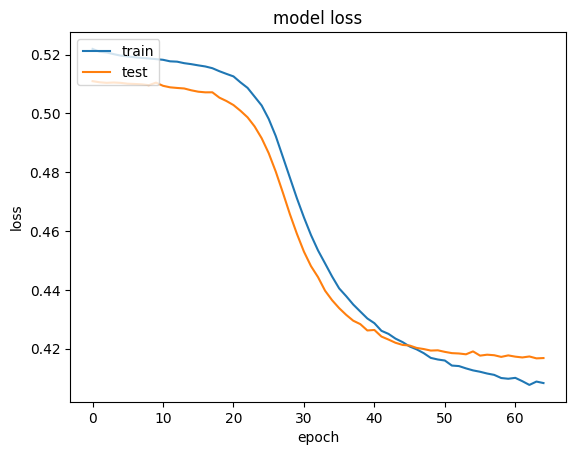

In [55]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Getting movies for given User:

In [56]:
def recommender_system(user_id, model, n_movies):

  print("")
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title']))
  print("")

  encoded_user_id = user_enc.transform([user_id])

  ##Id's of movies which are already seen by the user are extracted.
  seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id]['movie'])

  ##Movies which are not seen by the user.
  unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]

  ##DNN model is used to predict the ratings of the unseen movies.
  model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
  predicted_ratings = model.predict(model_input)
  predicted_ratings = np.max(predicted_ratings, axis=1)

  ##Sorting
  sorted_index = np.argsort(predicted_ratings)[::-1]
  recommended_movies = item_enc.inverse_transform(sorted_index)

  print("---------------------------------------------------------------------------------")
  print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
  pprint(list(recommended_movies[:n_movies]))

In [62]:
print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,model,n_movies)


Enter user id
112
Enter number of movies to be recommended:
5

Movie seen by the User:
['Afterglow (1997)',
 'Air Force One (1997)',
 'Amistad (1997)',
 'Apt Pupil (1998)',
 'As Good As It Gets (1997)',
 'Bent (1997)',
 'Conspiracy Theory (1997)',
 'Contact (1997)',
 'Cop Land (1997)',
 'Crash (1996)',
 "Dante's Peak (1997)",
 "Devil's Advocate, The (1997)",
 "Devil's Own, The (1997)",
 'Edge, The (1997)',
 'English Patient, The (1996)',
 "Eve's Bayou (1997)",
 'Evita (1996)',
 'Full Monty, The (1997)',
 'Game, The (1997)',
 'Good Will Hunting (1997)',
 'In & Out (1997)',
 'Jackal, The (1997)',
 'Jackie Brown (1997)',
 'Kiss the Girls (1997)',
 'L.A. Confidential (1997)',
 'Liar Liar (1997)',
 'Mad City (1997)',
 'Midnight in the Garden of Good and Evil (1997)',
 'Mother (1996)',
 'Mrs. Brown (Her Majesty, Mrs. Brown) (1997)',
 'Murder at 1600 (1997)',
 'Newton Boys, The (1998)',
 'One Night Stand (1997)',
 'Peacemaker, The (1997)',
 'Rainmaker, The (1997)',
 'Red Corner (1997)',
 'Sai